In [35]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
# from sklearn.utils import shuffle

from mne import Epochs, pick_types, annotations_from_events, events_from_annotations, set_log_level, read_epochs
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP 
# from mne.viz import plot_events, plot_montage

import joblib

In [37]:
path = os.getenv('HOME') + '/goinfre'

experiments = [
    {
        "description": "open and close left or right fist",
        "runs": [3, 7, 11],
        "mapping": {0: "rest", 1: "left fist", 2: "right fist"},
    },
    {
        "description": "imagine opening and closing left or right fist",
        "runs": [4, 8, 12],
        "mapping": {0: "rest", 1: "imagine left fist", 2: "imagine right fist"},
    },
    {
        "description": "open and close both fists or both feet",
        "runs": [5, 9, 13],
        "mapping": {0: "rest", 1: "both fists", 2: "both feets"},
    },
    {
        "description": "imagine opening and closing both fists or both feet",
        "runs": [6, 10, 14],
        "mapping": {0: "rest", 1: "imagine both fists", 2: "imagine both feets"},
    },
    {
        "description": "movement (real or imagine) of fists",
        "runs": [3, 7, 11, 4, 8, 12],
        "mapping": {0: "rest", 1: "left fist", 2: "right fist"},
    },
    {
        "description": "movement (real or imagine) of both fists or both feet",
        "runs": [5, 9, 13, 6, 10, 14],
        "mapping": {0: "rest", 1: "both fists", 2: "both feets"},
    },
]

In [38]:
exp_set = 0
subject_nb = 1
experiment = experiments[exp_set]
tmin, tmax = -1.0, 4.0

subject_raws = []
raw_fnames = eegbci.load_data(subject_nb, experiment["runs"])
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
events, _ = events_from_annotations(raw, event_id=dict(T1=1, T2=2))
annot_from_events = annotations_from_events(
    events=events, event_desc=experiment["mapping"], sfreq=raw.info["sfreq"]
)
raw.set_annotations(annot_from_events)

eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
channels = raw.info["ch_names"]
good_channels = ["FC5", "FC3", "FC1", "FCz", "FC2", "FC4", "FC6",
                          "C5",  "C3",  "C1",  "Cz",  "C2",  "C4",  "C6",
                         "CP5", "CP3", "CP1", "CPz", "CP2", "CP4", "CP6"]
bad_channels = [x for x in channels if x not in good_channels]
raw.drop_channels(bad_channels)

# Apply band-pass filter
raw.notch_filter(60, method="iir")
raw.filter(7.0, 32.0, fir_design="firwin", skip_by_annotation="edge")

Extracting EDF parameters from /mnt/nfs/homes/clorin/goinfre/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Extracting EDF parameters from /mnt/nfs/homes/clorin/goinfre/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Extracting EDF parameters from /mnt/nfs/homes/clorin/goinfre/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Extracting EDF parameters from /mnt/nfs/homes/clorin/goinfre/MNE-eegbci-data/files/eegmmidb/1.0.0/S100/S100R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      

/tmp/ipykernel_1654961/2269469255.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
/tmp/ipykernel_1654961/2269469255.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
/tmp/ipykernel_1654961/2269469255.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
/tmp/ipykernel_1654961/2269469255.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
/tmp/ipykernel_1654961/2269469255.py:8: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw

<RawEDF | S100R05.edf, 21 x 94464 (738.0 s), ~15.2 MB, data loaded>

In [39]:
# Read epochs
events, event_id = events_from_annotations(raw)
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
labels = epochs.events[:, -1]
# print(labels)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=4.0).get_data()
print(epochs_train.shape)
# cv = ShuffleSplit(10, test_size=0.2)

Used Annotations descriptions: ['both feets', 'both fists']
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 641 original time points ...
0 bad epochs dropped
(72, 21, 385)


In [45]:
# Assemble a classifier
csp = CSP(6)
lda = LinearDiscriminantAnalysis()
clf = Pipeline([("CSP", csp), ("LDA", lda)])

# fit our pipeline to the experiment
X_train, X_test, y_train, y_test = train_test_split(epochs_train, labels, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 21 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 21 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.


0.6111111111111112

Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 1.7e-05 (2.2e-16 eps * 21 dim * 3.6e+09  max singular value)
Computing rank from data with rank=None
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 1.1e-05 (2.2e-16 eps * 21 dim * 2.3e+09  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Reducing data rank from 21 -> 21
Computing rank from data with rank=None
    Using toleranc

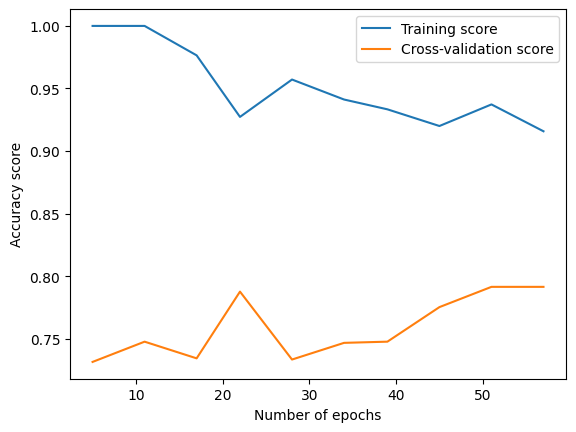

In [46]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(clf, epochs_train, labels, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

In [41]:
predictions = clf.predict(X_test)
print(f'epoch nb: [prediction] [truth] equal?')
for i, prediction in enumerate(predictions):
    print(f'epoch {i:02d}: [{prediction}] [{y_test[i]}] {prediction == y_test[i]}')
    time.sleep(0.05)

score_subject = accuracy_score(predictions, y_test)
print(f'mean accuracy for all experiments:{score_subject}')

epoch nb: [prediction] [truth] equal?
epoch 00: [2] [1] False
epoch 01: [2] [2] True
epoch 02: [1] [1] True
epoch 03: [2] [1] False
epoch 04: [2] [1] False
epoch 05: [1] [1] True
epoch 06: [2] [2] True
epoch 07: [1] [1] True
epoch 08: [2] [1] False
epoch 09: [1] [1] True
epoch 10: [1] [2] False
epoch 11: [2] [1] False
epoch 12: [2] [2] True
epoch 13: [2] [1] False
epoch 14: [1] [1] True
epoch 15: [1] [1] True
epoch 16: [2] [2] True
epoch 17: [2] [2] True
mean accuracy for all experiments:0.6111111111111112
